In [428]:
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier 

In [183]:
hist = pd.read_csv('users_history.csv')
hist.drop(columns=['started_at','read_at'], inplace=True)

In [450]:
hist = pd.read_csv('users_history.csv')

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [451]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458921 entries, 0 to 458920
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             458921 non-null  int64  
 1   rating                         458921 non-null  int64  
 2   started_at                     208605 non-null  object 
 3   read_at                        263231 non-null  object 
 4   book.id.#text                  458921 non-null  int64  
 5   book.isbn13.@nil               46380 non-null   object 
 6   book.text_reviews_count.#text  458921 non-null  int64  
 7   book.num_pages                 417638 non-null  float64
 8   book.publication_year          405035 non-null  float64
 9   book.average_rating            458921 non-null  float64
 10  book.ratings_count             458921 non-null  int64  
 11  user_id                        458921 non-null  int64  
 12  book.isbn13                   

In [177]:
data.user_id.nunique()

3090

In [184]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458921 entries, 0 to 458920
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             458921 non-null  int64  
 1   rating                         458921 non-null  int64  
 2   book.id.#text                  458921 non-null  int64  
 3   book.isbn13.@nil               46380 non-null   object 
 4   book.text_reviews_count.#text  458921 non-null  int64  
 5   book.num_pages                 417638 non-null  float64
 6   book.publication_year          405035 non-null  float64
 7   book.average_rating            458921 non-null  float64
 8   book.ratings_count             458921 non-null  int64  
 9   user_id                        458921 non-null  int64  
 10  book.isbn13                    259593 non-null  object 
dtypes: float64(3), int64(6), object(2)
memory usage: 38.5+ MB


In [433]:
hist['book.id.#text'].nunique()

161572

In [185]:
# Import Reviewers
users = pd.read_csv('users_jellicoe.csv')
user_ids = []
for user in users.user_url:
    user_ids.append(''.join(filter(lambda i: i.isdigit(), user)))
users['user_id'] = user_ids
users = users.iloc[:,[-1,6]]

In [186]:
#hist['read_at'], hist['started_at'] = pd.to_datetime(hist['read_at']), pd.to_datetime(hist['started_at'])
hist['rating_bias'] = hist['rating'] - hist['book.average_rating']
#hist['reading_time'] = hist['read_at'] - hist['started_at']

In [ ]:
hist.reading_time.mean()

#### Reader Level Features

In [187]:
reader_features = (['reader_avg_publ_year', 'reader_avg_rating', 'reader_avg_book_length',
                    'reader_avg_book_rating','reader_avg_rating bias', 'reader_avg_book_popularity',])

df_reader_feats = (hist.groupby(['user_id'], as_index=False).agg(OrderedDict([('book.publication_year','mean'),
                                                                              ('rating', 'mean'),
                                                                              ('book.average_rating', 'mean'),
                                                                              ('book.num_pages', 'mean'),
                                                                              ('rating_bias', 'mean'),
                                                                              ('book.ratings_count', 'mean')])))
df_reader_feats.columns = ['user_id'] + reader_features

#df_reader_feats['reader_med_reading_time'] = df_reader_feats.reader_med_reading_time.dt.days

In [163]:
#df_reader_feats = df_reader_feats.drop(columns=['reader_med_reading_time'])

In [188]:
# IDK why the merge doesn't work with object type
df_reader_feats['user_id'] = df_reader_feats.user_id.astype('int')
users['user_id'] = users.user_id.astype('int')
df_X = df_reader_feats.merge(users, how='left', on='user_id')

# Convert rating to target
df_X['rating'] = df_X.rating.apply(lambda x: x>=4).astype(int)

In [191]:
df_X.columns

Index(['user_id', 'reader_avg_publ_year', 'reader_avg_rating',
       'reader_avg_book_length', 'reader_avg_book_rating',
       'reader_avg_rating bias', 'reader_avg_book_popularity', 'rating'],
      dtype='object')

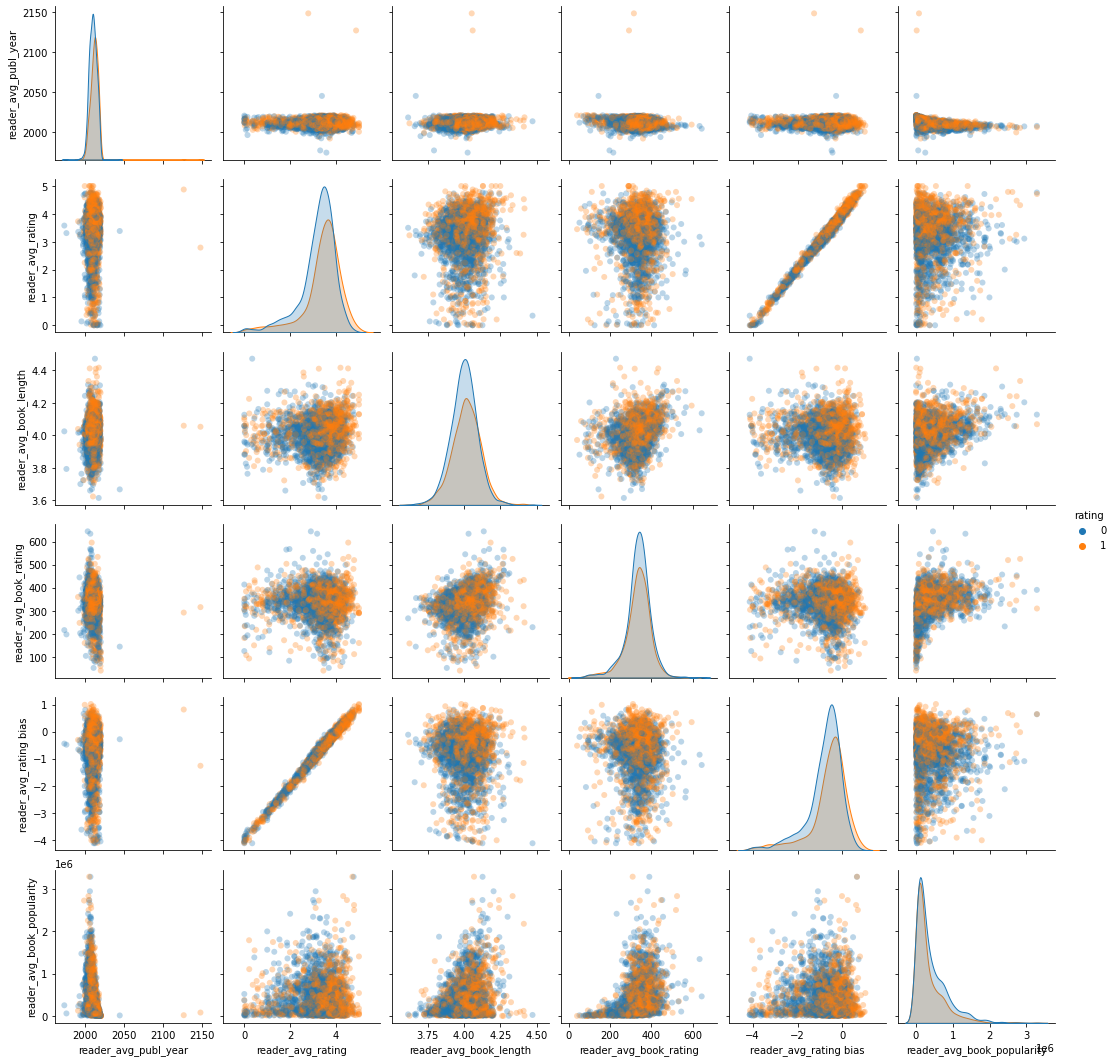

In [192]:
sns.pairplot(df_X.iloc[:,1:], hue='rating', plot_kws=dict(alpha=.3, edgecolor='none'))

In [199]:
df_X = df_X.dropna()

In [326]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [435]:
def get_performance(df, model_type, cutoff=.5):
    X_tr, X_te, y_tr, y_te = get_reader_split_data(df)
    model = model_type
    model.fit(X_tr, y_tr)
    y_pred = (model.predict_proba(X_te)[:,1]>cutoff)
    #print(model_type)
    metrics = (OrderedDict([('Model', str(model_type)),
                            ('Precision', precision_score(y_te, y_pred)),
                            ('Recall', recall_score(y_te, y_pred)),
                            ('F1', f1_score(y_te, y_pred)),
                            #('Data', namestr(df,globals())[0])
                           ]))
   #print('Confusion Matrix:')
   #print(confusion_matrix(y_te, y_pred))
    return metrics


In [438]:
def plot_performance_across_models(df, models, cutoff=.5):
    metrics = []
    for model in models:
        metrics.append(get_performance(df, model))
    metrics_df = pd.DataFrame(metrics)
    metrics_melt = pd.melt(metrics_df, id_vars=['Model']) #'Data'
    for metric in metrics:
        sns.barplot(y='value', x='variable', hue='Model', data=metrics_melt, palette='Paired')

In [365]:
def plot_metrics(metrics_df):
    metrics_melt = pd.melt(pd.DataFrame(metrics_df), id_vars=['Model'])

In [375]:
def get_metrics_plot(datasets, cutoff=.5):
    models = [LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier()]
    metrics_list = []
    for model in models:
        for dataset in datasets:
            metrics_list.append(get_performance(dataset, model, cutoff))
    metrics_df = pd.DataFrame(metrics_list)
    metrics_melt = pd.melt(metrics_df, id_vars=['Model','Data'])
    sns.relplot(kind='line', y='value', x='variable', hue='Model', style='Data', data=metrics_melt)
    #return metrics_melt

In [447]:
models = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]
metrics = []
for model in models:
    performance = get_performance(df_X, model)
    metrics.append(performance)

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [448]:
metrics_melt = pd.melt(pd.DataFrame(metrics), id_vars=['Model'])

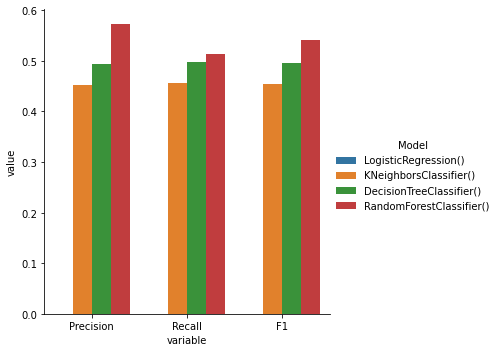

In [449]:
sns.catplot(kind='bar', y='value', x='variable', data=pd.melt(pd.DataFrame(metrics), id_vars=['Model']), hue='Model')

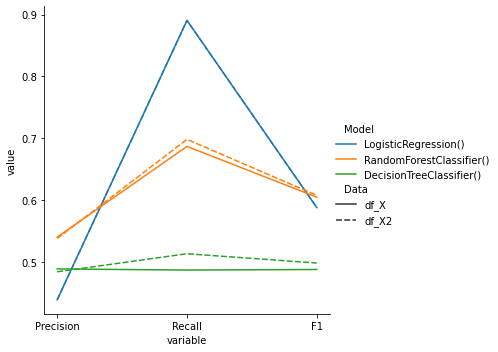

In [377]:
get_metrics_plot([df_X, df_X2],.4)

In [ ]:
df1_daily = df1_daily.sort

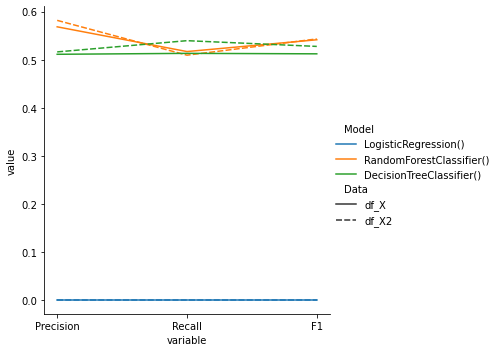

In [360]:
sns.relplot(kind='line', y='value', x='variable', hue='Model', style='Data', data=metrics_melt)

In [344]:
test

,Model,Data,variable,value
0,LogisticRegression(),df_X,Precision,0.000000
1,DecisionTreeClassifier(),df_X,Precision,0.487179
2,RandomForestClassifier(),df_X,Precision,0.576271
3,LogisticRegression(),df_X,Recall,0.000000
4,DecisionTreeClassifier(),df_X,Recall,0.501887
5,RandomForestClassifier(),df_X,Recall,0.513208
6,LogisticRegression(),df_X,F1,0.000000
7,DecisionTreeClassifier(),df_X,F1,0.494424
8,RandomForestClassifier(),df_X,F1,0.542914


In [347]:
test.Data[0]

'df_X'

<AxesSubplot:xlabel='variable', ylabel='value'>

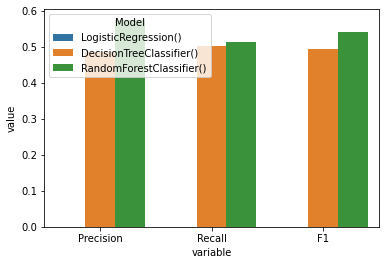

In [346]:
sns.barplot(y='value', x='variable', hue='Model', data=test)

#### Logistic Regression

In [415]:
X_tr, X_te, y_tr, y_te = get_reader_split_data(df_X)

lr = LogisticRegression(C=100)
lr.fit(X_tr, y_tr)
f1_score(y_te, lr.predict(X_te))

0.0

In [416]:
y_pred = (lr.predict_proba(X_te)[:,1]>0.4)
y_pred = lr.predict(X_te)

print(f'Precision: {precision_score(y_te, y_pred)}')
print(f'Recall: {recall_score(y_te, y_pred)}')
print(f'F1: {f1_score(y_te, y_pred)}')

Precision: 0.0
Recall: 0.0
F1: 0.0


/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [417]:
confusion_matrix(y_te, y_pred)

array([[346,   0],
       [265,   0]])

#### Decision Tree

In [418]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [419]:
dtree = DecisionTreeClassifier(max_depth=4)
dtree.fit(X_tr, y_tr)
f1_score(y_te, dtree.predict(X_te))

0.5206611570247934

In [420]:
y_pred_dt = (dtree.predict_proba(X_te)[:,1]>0.4)
y_pred_dt = dtree.predict(X_te)

print(f'Precision: {precision_score(y_te, y_pred_dt)}')
print(f'Recall: {recall_score(y_te, y_pred_dt)}')
print(f'F1: {f1_score(y_te, y_pred_dt)}')

Precision: 0.5753424657534246
Recall: 0.47547169811320755
F1: 0.5206611570247934


In [421]:
confusion_matrix(y_te, y_pred_dt)

array([[253,  93],
       [139, 126]])

#### Random Forest

In [422]:
randf = RandomForestClassifier()
randf.fit(X_tr, y_tr)
f1_score(randf.predict(X_te), y_te)

0.5373737373737373

In [423]:
y_pred_rf = randf.predict(X_te)

print(f'Precision: {precision_score(y_te, y_pred_rf)}')
print(f'Recall: {recall_score(y_te, y_pred_rf)}')
print(f'F1: {f1_score(y_te, y_pred_rf)}')

Precision: 0.5782608695652174
Recall: 0.5018867924528302
F1: 0.5373737373737373


In [424]:
confusion_matrix(y_te, y_pred_rf)

array([[249,  97],
       [132, 133]])

#### kNN 

In [429]:
knn = KNeighborsClassifier()
knn.fit(X_tr, y_tr)
f1_score(knn.predict(X_te), y_te)

0.4540337711069418

In [425]:
def get_reader_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_readers = users['user_id'].unique() 
    test_readers = rs.choice(total_readers,
                             size=int(total_readers.shape[0] * test_size),
                             replace=False)

    df_tr = df[~df['user_id'].isin(test_readers)]
    df_te = df[df['user_id'].isin(test_readers)] 

    y_tr, y_te = df_tr['rating'], df_te['rating']
    X_tr, X_te = df_tr.iloc[:,1:-1], df_te.iloc[:,1:-1]

    return X_tr, X_te, y_tr, y_te

### ROC Curve

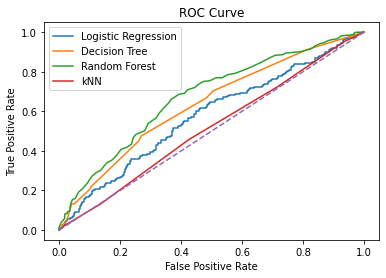

In [432]:
fpr, tpr, _ = roc_curve(y_te, lr.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_te, dtree.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_te, randf.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_te, knn.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Logistic Regression','Decision Tree','Random Forest','kNN'])